In [1]:
import pandas as pd
import optuna
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import warnings
from sklearn.preprocessing import LabelEncoder

c:\Users\dayth\anaconda3\envs\dsprojects\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('../../data/processed/data_final.csv')
df

,precio,banos,dormitorios,superficie_total,superficie_construida,estacionamiento,latitud,longitud,comuna,población 2024,...,pct_cocina_moderna,pct_propia_total,pct_arrendada,ingreso_promedio,ingreso_mediana,indice_calidad_materiales,indice_servicios_basicos,indice_calidad_vivienda_general,distancia_hospital,distancia_metro
0,322633576.0,3.0,5.0,404.0,275.0,1.0,-33.345468,-70.678398,huechuraba,101808.0,...,89.86,64.31,0.00,720051.66,402500.0,86.47,61.35,74.64,8064.787023,2554.229150
1,157180460.0,2.0,3.0,190.0,127.0,1.0,-33.563025,-70.559425,puente alto,568086.0,...,90.62,69.71,0.18,538232.86,400000.0,93.75,65.79,78.18,845.094730,2324.734493
2,133544301.0,2.0,5.0,146.0,61.0,1.0,-33.641678,-70.689872,san bernardo,306371.0,...,90.21,58.31,1.16,488733.18,400000.0,89.94,62.44,76.41,5475.616211,11151.846959
3,117786861.0,2.0,3.0,145.0,82.0,1.0,-33.613778,-70.887450,peñaflor,94402.0,...,89.12,65.85,0.19,591753.35,400000.0,84.18,62.29,77.28,1600.028166,16662.321199
4,153241100.0,4.0,4.0,172.0,82.0,1.0,-33.360659,-70.709209,quilicura,205624.0,...,93.53,61.08,0.38,549642.87,450000.0,94.77,67.11,74.76,7622.326772,1948.472205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4520,234059250.0,3.0,5.0,140.0,101.0,0.0,-33.488703,-70.744430,maipú,503635.0,...,92.76,70.40,0.80,601743.03,450000.0,94.91,69.46,78.23,3514.318855,711.188857
4521,95000000.0,2.0,6.0,110.0,95.0,0.0,-33.499393,-70.776072,maipú,503635.0,...,92.76,70.40,0.80,601743.03,450000.0,94.91,69.46,78.23,995.045138,1765.069675
4522,742425000.0,5.0,5.0,370.0,230.0,0.0,-33.421135,-70.553193,las condes,296134.0,...,98.33,56.67,0.49,1806493.23,1050000.0,97.94,92.51,77.68,4638.577959,1526.624955
4523,69709800.0,1.0,2.0,88.0,70.0,0.0,-33.513907,-70.783665,maipú,503635.0,...,92.76,70.40,0.80,601743.03,450000.0,94.91,69.46,78.23,1078.534716,2485.915755


Para poder trabajar correctamente con la columna de 'comuna' se requiere usar herramientas de encoding, esto debido a que random forest, xgboost y lgbm no pueden trabajar con strings(palabras), por lo que se requiere que se transformen a números, hay varios tipos de encoding, one-hot encoding, label encoding, o embedding, el que voy a usar es el label-encoding, el cual le asigna una secuencia de números a las categorías únicas de la variable, por ejemplo Alhué es 1 Buin 2 y así sucesivamente

In [3]:
le = LabelEncoder()
df['comuna'] = le.fit_transform(df['comuna'])

In [4]:
y = df['precio']
X = df.drop(columns=['precio'])

y_binned = pd.qcut(y, q=10, duplicates='drop')
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y_binned
)

print(f"Tamaño conjunto entrenamiento: {X_train.shape}")
print(f"Tamaño conjunto prueba: {X_test.shape}")

Tamaño conjunto entrenamiento: (3620, 162)
Tamaño conjunto prueba: (905, 162)


In [5]:
preprocessor = Pipeline([
    ('scaler', RobustScaler())
])

In [6]:
def calculate_metrics(y_true, y_pred):
    """Calcula todas las métricas requeridas"""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    mae_percentage = (mae / y_true.mean()) * 100
    
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    return {
        'MAE': mae,
        'MAE_%': mae_percentage,
        'RMSE': rmse,
        'R²': r2,
        'MAPE': mape
    }

In [7]:
def cv_log_corrected(pipeline, X, y, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    mae_scores = []
    r2_scores = []
    
    for train_idx, val_idx in kf.split(X):
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
        
        y_train_log_fold = np.log1p(y_train_fold)
        pipeline.fit(X_train_fold, y_train_log_fold)
        
        y_pred_log_fold = pipeline.predict(X_val_fold)
        y_pred_original_fold = np.expm1(y_pred_log_fold)
        
        mae_scores.append(mean_absolute_error(y_val_fold, y_pred_original_fold))
        r2_scores.append(r2_score(y_val_fold, y_pred_original_fold))
    
    return np.array(mae_scores), np.array(r2_scores)


In [8]:
print("RANDOM FOREST")

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42
    ))
])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
metrics_rf = calculate_metrics(y_test, y_pred_rf)

for metric, value in metrics_rf.items():
    print(f"{metric}: {value:.3f}")

RANDOM FOREST
MAE: 38973648.192
MAE_%: 17.125
RMSE: 62491256.644
R²: 0.868
MAPE: 20.707


In [9]:
print("XGBOOST")

xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(
        n_estimators=150,
        learning_rate=0.05,
        max_depth=4,
        reg_alpha=0.1,
        reg_lambda=1.0,
        random_state=42,
        verbosity=0
    ))
])

xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)
metrics_xgb = calculate_metrics(y_test, y_pred_xgb)

for metric, value in metrics_xgb.items():
    print(f"{metric}: {value:.3f}")

XGBOOST
MAE: 40227860.548
MAE_%: 17.676
RMSE: 62813562.165
R²: 0.866
MAPE: 21.026


In [10]:
import os
os.environ['LIGHTGBM_VERBOSE'] = '0' 

print("\n" + "="*40)
print("LIGHTGBM")
print("="*40)

lgbm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', lgb.LGBMRegressor(
        n_estimators=150,
        learning_rate=0.05,
        max_depth=4,
        random_state=42,
        verbose=-1
    ))
])

lgbm_pipeline.fit(X_train, y_train)
y_pred_lgbm = lgbm_pipeline.predict(X_test)
metrics_lgbm = calculate_metrics(y_test, y_pred_lgbm)

for metric, value in metrics_lgbm.items():
    print(f"{metric}: {value:.3f}")


LIGHTGBM
MAE: 39836320.906
MAE_%: 17.504
RMSE: 62362793.003
R²: 0.868
MAPE: 20.934


c:\Users\dayth\anaconda3\envs\dsprojects\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [11]:
resultados = {
    'Modelo': ['Random Forest', 'XGBoost', 'LightGBM'],
    'MAE': [metrics_rf['MAE'], metrics_xgb['MAE'], metrics_lgbm['MAE']],
    'MAE_%': [metrics_rf['MAE_%'], metrics_xgb['MAE_%'], metrics_lgbm['MAE_%']],
    'RMSE': [metrics_rf['RMSE'], metrics_xgb['RMSE'], metrics_lgbm['RMSE']],
    'R²': [metrics_rf['R²'], metrics_xgb['R²'], metrics_lgbm['R²']],
    'MAPE': [metrics_rf['MAPE'], metrics_xgb['MAPE'], metrics_lgbm['MAPE']]
}

df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.sort_values('MAE')

print(df_resultados.to_string(index=False, float_format='%.3f'))

mejor_modelo_final = df_resultados.iloc[0]['Modelo']
print(f"\nMEJOR MODELO: {mejor_modelo_final}")

       Modelo          MAE  MAE_%         RMSE    R²   MAPE
Random Forest 38973648.192 17.125 62491256.644 0.868 20.707
     LightGBM 39836320.906 17.504 62362793.003 0.868 20.934
      XGBoost 40227860.548 17.676 62813562.165 0.866 21.026

MEJOR MODELO: Random Forest


In [12]:
print("VALIDACIÓN CRUZADA - ANÁLISIS R² (K=5)")

pipelines_cv = {
    'Random Forest': rf_pipeline,
    'XGBoost': xgb_pipeline,
    'LightGBM': lgbm_pipeline
}

cv_results = {}

for name, pipeline in pipelines_cv.items():
    cv_r2 = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')
    
    cv_results[name] = {
        'CV_R²_mean': cv_r2.mean(),
        'CV_R²_std': cv_r2.std(),
        'CV_R²_scores': cv_r2
    }

print("Resultados de Validación Cruzada (R²):")
for modelo, resultados in cv_results.items():
    print(f"{modelo}:")
    print(f"  R² promedio: {resultados['CV_R²_mean']:.4f}")
    print(f"  R² desviación estándar: {resultados['CV_R²_std']:.4f}")
    print(f"  R² por fold: {[f'{score:.4f}' for score in resultados['CV_R²_scores']]}") 
    print()

mejor_cv_modelo = max(cv_results.items(), key=lambda x: x[1]['CV_R²_mean'])
print(f"🏆 MEJOR MODELO EN CV: {mejor_cv_modelo[0]} (R² = {mejor_cv_modelo[1]['CV_R²_mean']:.4f})")

VALIDACIÓN CRUZADA - ANÁLISIS R² (K=5)


c:\Users\dayth\anaconda3\envs\dsprojects\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\dayth\anaconda3\envs\dsprojects\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\dayth\anaconda3\envs\dsprojects\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\dayth\anaconda3\envs\dsprojects\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Resultados de Validación Cruzada (R²):
Random Forest:
  R² promedio: 0.8564
  R² desviación estándar: 0.0044
  R² por fold: ['0.8512', '0.8509', '0.8610', '0.8591', '0.8597']

XGBoost:
  R² promedio: 0.8586
  R² desviación estándar: 0.0095
  R² por fold: ['0.8437', '0.8529', '0.8700', '0.8593', '0.8669']

LightGBM:
  R² promedio: 0.8576
  R² desviación estándar: 0.0101
  R² por fold: ['0.8418', '0.8537', '0.8707', '0.8557', '0.8661']

🏆 MEJOR MODELO EN CV: XGBoost (R² = 0.8586)


c:\Users\dayth\anaconda3\envs\dsprojects\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [13]:
print(df.columns.tolist())

['precio', 'banos', 'dormitorios', 'superficie_total', 'superficie_construida', 'estacionamiento', 'latitud', 'longitud', 'comuna', 'población 2024', 'índice masculinidad 2024', 'grupo_etario_0_a_14_2024_(%)', 'grupo_etario_15_a_29_2024_(%)', 'grupo_etario_30_a_44_2024_(%)', 'grupo_etario_45_a_64_2024_(%)', 'grupo_etario_65_o_mas_2024_(%)', 'idd 2024', 'iam 2024', 'pobreza por ingresos 2022 (%)', 'pobreza multidimensional 2022 (%)', 'pueblos indígenas 2025 (%)', 'extranjeros 2025 (%)', 'carentes servicios básicos 2025 (%)', 'hogares hacinados 2025 (%)', 'cantidad de: atención remota 2025', 'cantidad de: centro comunitario de salud familiar (cecosf) 2025', 'cantidad de: centro comunitario de salud mental  (cosam) 2025', 'cantidad de: centro corporación para la nutrición infantil (conin) 2025', 'cantidad de: centro de apoyo comunitario para personas con demencia 2025', 'cantidad de: centro diagnóstico terapéutico y tratamiento privado (cdt) 2025', 'cantidad de: centro de diálisis 2025', 

In [14]:
rf_imp = rf_pipeline.named_steps['model'].feature_importances_
xgb_imp = xgb_pipeline.named_steps['model'].feature_importances_
lgbm_imp = lgbm_pipeline.named_steps['model'].feature_importances_

rf_norm = rf_imp / rf_imp.sum()
xgb_norm = xgb_imp / xgb_imp.sum()
lgbm_norm = lgbm_imp / lgbm_imp.sum()

df_importance = pd.DataFrame({
    'feature': X_train.columns,
    'RF': rf_norm,
    'XGB': xgb_norm,
    'LGBM': lgbm_norm
})
df_importance['Average'] = (df_importance['RF'] + df_importance['XGB'] + df_importance['LGBM']) / 3
df_importance = df_importance.sort_values('Average', ascending=False)

print(f"{'Rank':<4} {'Feature':<35} {'Average':<8} {'RF':<8} {'XGB':<8} {'LGBM':<8}")
print("-" * 80)

for i, (_, row) in enumerate(df_importance.head(20).iterrows(), 1):
    feature_name = row['feature'][:34] if len(row['feature']) > 34 else row['feature']
    print(f"{i:<4} {feature_name:<35} {row['Average']:<8.4f} "
          f"{row['RF']:<8.4f} {row['XGB']:<8.4f} {row['LGBM']:<8.4f}")
    
top_20_variables = df_importance.head(20)['feature'].tolist()

df_export = X[top_20_variables].copy()
df_export['precio'] = y

df_export = df_export[['precio'] + top_20_variables]

df_export.to_csv('../../data/processed/dataset_variables_finales.csv', index=False)

print(f"  Columnas: {list(df_export.columns)}")

Rank Feature                             Average  RF       XGB      LGBM    
--------------------------------------------------------------------------------
1    matrícula particular pagado 2024    0.2257   0.2596   0.3904   0.0271  
2    superficie_total                    0.1751   0.2969   0.0353   0.1931  
3    simce 4to básico lectura 2022       0.0941   0.1288   0.1389   0.0144  
4    banos                               0.0599   0.0593   0.0184   0.1020  
5    superficie_construida               0.0530   0.0467   0.0114   0.1009  
6    longitud                            0.0394   0.0247   0.0065   0.0870  
7    latitud                             0.0272   0.0153   0.0040   0.0622  
8    distancia_metro                     0.0271   0.0133   0.0027   0.0651  
9    simce 4to básico matemáticas 2022   0.0263   0.0624   0.0137   0.0029  
10   distancia_hospital                  0.0234   0.0115   0.0023   0.0565  
11   dormitorios                         0.0204   0.0081   0.0030   0.05

In [15]:
X_reduced = X[top_20_variables]

X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(
    X_reduced, y, test_size=0.2, random_state=42, stratify=y_binned
)

In [16]:
print("RANDOM FOREST")

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=5,
        bootstrap=True,
        max_samples=None,
        max_features='sqrt',
        random_state=42
    ))
])

rf_pipeline.fit(X_train_reduced, y_train_reduced)
y_pred_rf = rf_pipeline.predict(X_test_reduced)
metrics_rf = calculate_metrics(y_test_reduced, y_pred_rf)

for metric, value in metrics_rf.items():
    print(f"{metric}: {value:.3f}")

RANDOM FOREST
MAE: 40438200.734
MAE_%: 17.769
RMSE: 62782522.451
R²: 0.867
MAPE: 21.960



ANÁLISIS DE MAE% POR RANGOS DE PRECIO
ANÁLISIS DE MAE% POR RANGOS DE PRECIO

Tabla completa de resultados:
Rango   Precio_Min   Precio_Max Precio_Promedio         MAE   MAE%  Cantidad_Casas
   Q1  $37,984,320  $99,473,400     $81,464,059 $31,469,283 38.63%             175
   Q2  $99,983,520 $139,969,080    $121,719,111 $24,903,099 20.46%             187
   Q4 $193,028,635 $323,730,000    $250,933,823 $44,380,985 17.69%             181
   Q3 $140,000,000 $189,960,840    $163,327,148 $27,067,715 16.57%             181
   Q5 $333,540,000 $898,725,000    $519,129,591 $74,587,586 14.37%             181

🔴 RANGO CON MAYOR MAE%:
   • Rango: Q1
   • MAE%: 38.63%
   • Rango de precios: $37,984,320 - $99,473,400
   • Precio promedio: $81,464,059
   • Cantidad de casas: 175

🟢 RANGO CON MENOR MAE%:
   • Rango: Q5
   • MAE%: 14.37%
   • Rango de precios: $333,540,000 - $898,725,000
   • Precio promedio: $519,129,591
   • Cantidad de casas: 181

--------------------------------------------------
A

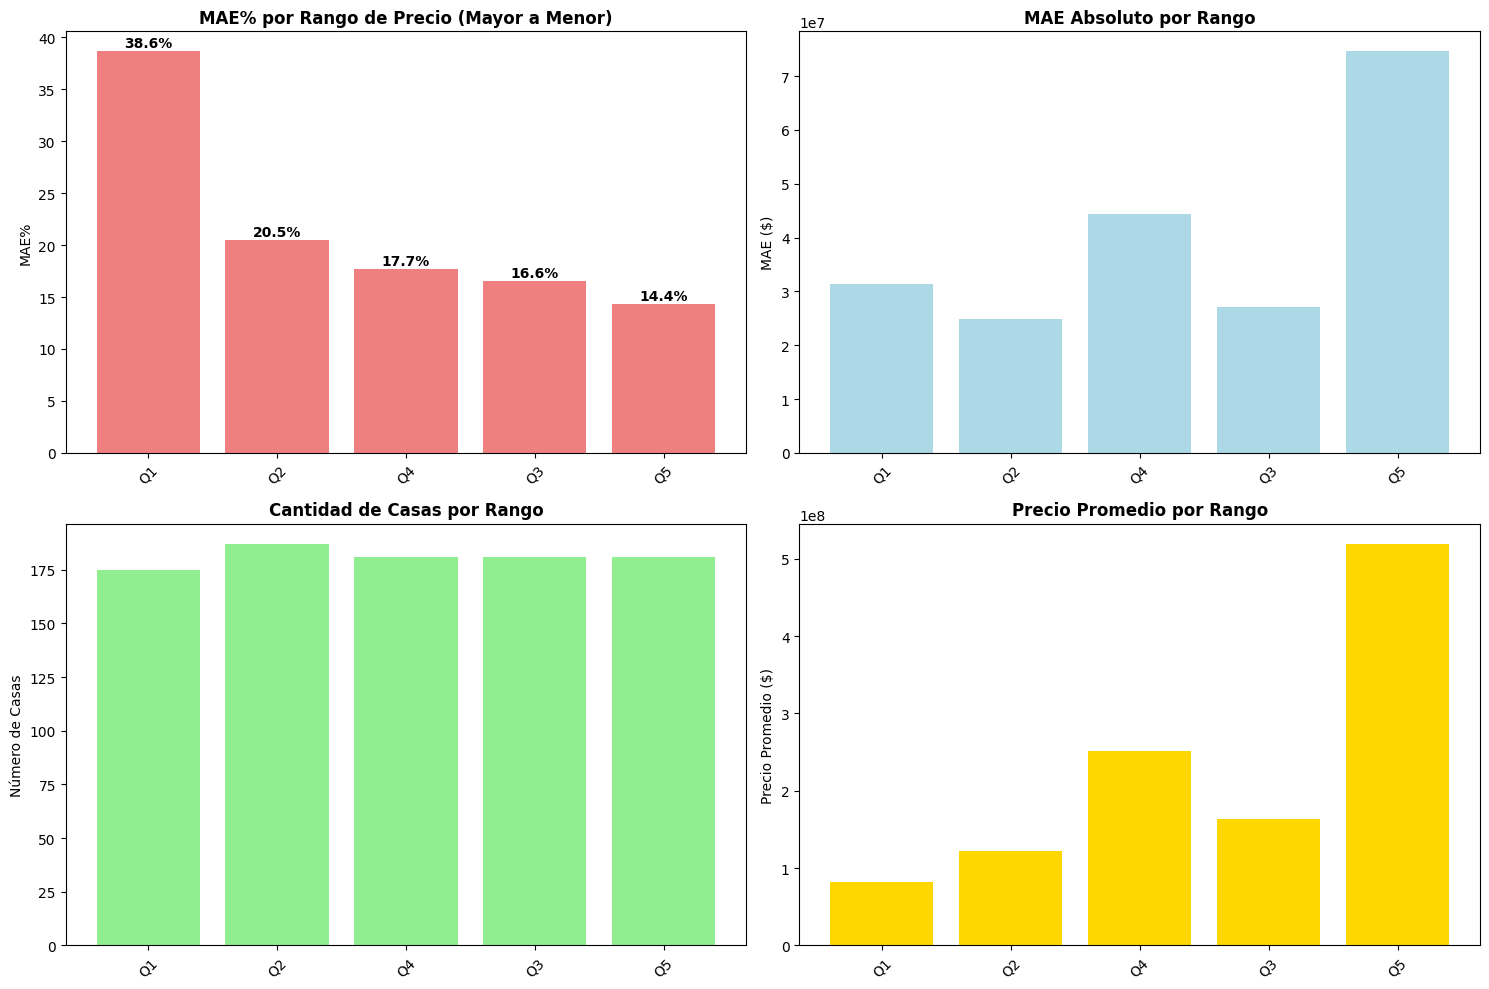

In [17]:
def analyze_mae_by_price_ranges(y_true, y_pred, n_bins=5, method='quantiles'):
    """
    Analiza MAE% por rangos de precio
    
    Parameters:
    - y_true: valores reales
    - y_pred: predicciones del modelo
    - n_bins: número de rangos a crear
    - method: 'quantiles' (misma cantidad por rango) o 'equal_width' (rangos de igual amplitud)
    """
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Crear bins según el método elegido
    if method == 'quantiles':
        # Quantiles: cada rango tiene aproximadamente la misma cantidad de casas
        bin_edges = np.quantile(y_true, np.linspace(0, 1, n_bins + 1))
        labels = [f'Q{i+1}' for i in range(n_bins)]
    else:  # equal_width
        # Igual amplitud: rangos de igual tamaño de precio
        bin_edges = np.linspace(y_true.min(), y_true.max(), n_bins + 1)
        labels = [f'Rango_{i+1}' for i in range(n_bins)]
    
    # Asignar cada casa a un bin
    bin_indices = np.digitize(y_true, bin_edges) - 1
    # Ajustar valores en el borde superior
    bin_indices = np.clip(bin_indices, 0, n_bins - 1)
    
    results = []
    
    for i in range(n_bins):
        mask = bin_indices == i
        
        if np.sum(mask) == 0:
            continue
            
        y_true_bin = y_true[mask]
        y_pred_bin = y_pred[mask]
        
        # Calcular métricas
        mae = np.mean(np.abs(y_true_bin - y_pred_bin))
        mae_percent = (mae / np.mean(y_true_bin)) * 100
        rmse = np.sqrt(np.mean((y_true_bin - y_pred_bin) ** 2))
        
        results.append({
            'Rango': labels[i],
            'Precio_Min': f"${y_true_bin.min():,.0f}",
            'Precio_Max': f"${y_true_bin.max():,.0f}",
            'Precio_Promedio': f"${y_true_bin.mean():,.0f}",
            'Precio_Promedio_Num': y_true_bin.mean(),  # Para ordenar
            'MAE': f"${mae:,.0f}",
            'MAE_Num': mae,  # Para ordenar
            'MAE%': f"{mae_percent:.2f}%",
            'MAE%_Num': mae_percent,  # Para ordenar
            'RMSE': f"${rmse:,.0f}",
            'Cantidad_Casas': int(np.sum(mask))
        })
    
    df_results = pd.DataFrame(results)
    
    # Ordenar por MAE% descendente para ver cuál es peor
    df_results = df_results.sort_values('MAE%_Num', ascending=False)
    
    return df_results

def plot_mae_by_price_ranges(df_results):
    """Visualiza los resultados del análisis"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # MAE% por rango (ordenado de mayor a menor)
    x_pos = range(len(df_results))
    axes[0,0].bar(x_pos, df_results['MAE%_Num'], color='lightcoral')
    axes[0,0].set_title('MAE% por Rango de Precio (Mayor a Menor)', fontweight='bold')
    axes[0,0].set_ylabel('MAE%')
    axes[0,0].set_xticks(x_pos)
    axes[0,0].set_xticklabels(df_results['Rango'], rotation=45)
    
    # Agregar valores sobre las barras
    for i, v in enumerate(df_results['MAE%_Num']):
        axes[0,0].text(i, v + 0.1, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # MAE absoluto por rango
    axes[0,1].bar(x_pos, df_results['MAE_Num'], color='lightblue')
    axes[0,1].set_title('MAE Absoluto por Rango', fontweight='bold')
    axes[0,1].set_ylabel('MAE ($)')
    axes[0,1].set_xticks(x_pos)
    axes[0,1].set_xticklabels(df_results['Rango'], rotation=45)
    
    # Cantidad de casas por rango
    axes[1,0].bar(x_pos, df_results['Cantidad_Casas'], color='lightgreen')
    axes[1,0].set_title('Cantidad de Casas por Rango', fontweight='bold')
    axes[1,0].set_ylabel('Número de Casas')
    axes[1,0].set_xticks(x_pos)
    axes[1,0].set_xticklabels(df_results['Rango'], rotation=45)
    
    # Precio promedio por rango
    axes[1,1].bar(x_pos, df_results['Precio_Promedio_Num'], color='gold')
    axes[1,1].set_title('Precio Promedio por Rango', fontweight='bold')
    axes[1,1].set_ylabel('Precio Promedio ($)')
    axes[1,1].set_xticks(x_pos)
    axes[1,1].set_xticklabels(df_results['Rango'], rotation=45)
    
    plt.tight_layout()
    plt.show()

def print_summary(df_results):
    """Imprime un resumen del análisis"""
    print("="*80)
    print("ANÁLISIS DE MAE% POR RANGOS DE PRECIO")
    print("="*80)
    
    # Mostrar tabla completa
    display_cols = ['Rango', 'Precio_Min', 'Precio_Max', 'Precio_Promedio', 
                   'MAE', 'MAE%', 'Cantidad_Casas']
    print("\nTabla completa de resultados:")
    print(df_results[display_cols].to_string(index=False))
    
    # Destacar el peor rango
    worst_range = df_results.iloc[0]
    print(f"\n🔴 RANGO CON MAYOR MAE%:")
    print(f"   • Rango: {worst_range['Rango']}")
    print(f"   • MAE%: {worst_range['MAE%']}")
    print(f"   • Rango de precios: {worst_range['Precio_Min']} - {worst_range['Precio_Max']}")
    print(f"   • Precio promedio: {worst_range['Precio_Promedio']}")
    print(f"   • Cantidad de casas: {worst_range['Cantidad_Casas']}")
    
    # Destacar el mejor rango
    best_range = df_results.iloc[-1]
    print(f"\n🟢 RANGO CON MENOR MAE%:")
    print(f"   • Rango: {best_range['Rango']}")
    print(f"   • MAE%: {best_range['MAE%']}")
    print(f"   • Rango de precios: {best_range['Precio_Min']} - {best_range['Precio_Max']}")
    print(f"   • Precio promedio: {best_range['Precio_Promedio']}")
    print(f"   • Cantidad de casas: {best_range['Cantidad_Casas']}")

# CÓDIGO PARA USAR DESPUÉS DE TU MODELO:

# Después de obtener tus predicciones:
y_pred_rf = rf_pipeline.predict(X_test_reduced)

# Analizar MAE% por rangos de precio
print("\n" + "="*50)
print("ANÁLISIS DE MAE% POR RANGOS DE PRECIO")
print("="*50)

# Análisis con quantiles (recomendado - misma cantidad de casas por rango)
results_quantiles = analyze_mae_by_price_ranges(y_test_reduced, y_pred_rf, 
                                               n_bins=5, method='quantiles')
print_summary(results_quantiles)

# Opcional: también puedes probar con rangos de igual amplitud
print("\n" + "-"*50)
print("ANÁLISIS ALTERNATIVO - RANGOS DE IGUAL AMPLITUD")
print("-"*50)
results_equal = analyze_mae_by_price_ranges(y_test_reduced, y_pred_rf, 
                                           n_bins=5, method='equal_width')
print_summary(results_equal)

# Crear visualizaciones
plot_mae_by_price_ranges(results_quantiles)

In [18]:
print("XGBOOST")

xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(
        n_estimators=150,
        learning_rate=0.05,
        max_depth=4,
        reg_alpha=0.1,
        reg_lambda=1.0,
        random_state=42,
        verbosity=0
    ))
])

xgb_pipeline.fit(X_train_reduced, y_train_reduced)
y_pred_xgb = xgb_pipeline.predict(X_test_reduced)
metrics_xgb = calculate_metrics(y_test_reduced, y_pred_xgb)

for metric, value in metrics_xgb.items():
    print(f"{metric}: {value:.3f}")

XGBOOST
MAE: 40306265.551
MAE_%: 17.711
RMSE: 62868644.020
R²: 0.866
MAPE: 21.334


In [19]:
print("LIGHTGBM")

lgbm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', lgb.LGBMRegressor(
        n_estimators=150,
        learning_rate=0.05,
        max_depth=4,
        random_state=42,
        verbose=-1,
        num_leaves=50,
        min_child_samples=1
    ))
])

lgbm_pipeline.fit(X_train_reduced, y_train_reduced)
y_pred_lgbm = lgbm_pipeline.predict(X_test_reduced)
metrics_lgbm = calculate_metrics(y_test_reduced, y_pred_lgbm)

for metric, value in metrics_lgbm.items():
    print(f"{metric}: {value:.3f}")

LIGHTGBM
MAE: 40648616.692
MAE_%: 17.861
RMSE: 64049321.609
R²: 0.861
MAPE: 21.342


c:\Users\dayth\anaconda3\envs\dsprojects\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [20]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings('ignore')

class TqdmCallback:
    def __init__(self, n_trials):
        self.pbar = tqdm(
            total=n_trials, 
            desc="🌲 Optimizing RF",
            bar_format='{desc}: {percentage:3.0f}%|{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}] {postfix}',
            ncols=100
        )
        self.best_score = float('-inf')
        
    def __call__(self, study, trial):
        if study.best_value > self.best_score:
            self.best_score = study.best_value
            
        self.pbar.update(1)
        self.pbar.set_postfix({
            'Best': f'{-self.best_score:.0f}',  
            'Current': f'{-trial.value:.0f}' if trial.value else 'Failed'
        })
        
    def close(self):
        self.pbar.close()

def objective(trial):
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': bootstrap,
        'random_state': 42
    }
    
    if bootstrap:
        params['max_samples'] = trial.suggest_float('max_samples', 0.7, 1.0)
    
    rf_pipeline_trial = Pipeline([
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(**params))
    ])
    
    scores = cross_val_score(
        rf_pipeline_trial, 
        X_train_reduced, 
        y_train_reduced, 
        cv=3,  
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    
    return scores.mean()

def print_comparison_table(metrics_original, metrics_optimized):
    comparison_data = {
        'Modelo Original': [
            f"{metrics_original['MAE']:.0f}",
            f"{metrics_original['MAE_%']:.2f}%",
            f"{metrics_original['RMSE']:.0f}",
            f"{metrics_original['R²']:.4f}",
            f"{metrics_original['MAPE']:.2f}%"
        ],
        'Modelo Optimizado': [
            f"{metrics_optimized['MAE']:.0f}",
            f"{metrics_optimized['MAE_%']:.2f}%",
            f"{metrics_optimized['RMSE']:.0f}",
            f"{metrics_optimized['R²']:.4f}",
            f"{metrics_optimized['MAPE']:.2f}%"
        ],
        'Mejora': []
    }
    
    # Calcular mejoras
    for metric in ['MAE', 'MAE_%', 'RMSE', 'R²', 'MAPE']:
        if metric == 'R²':
            improvement = ((metrics_optimized[metric] - metrics_original[metric]) / abs(metrics_original[metric])) * 100
        else:
            improvement = ((metrics_original[metric] - metrics_optimized[metric]) / abs(metrics_original[metric])) * 100
        comparison_data['Mejora'].append(f"{improvement:+.2f}%")
    
    df_comparison = pd.DataFrame(comparison_data, 
                                index=['MAE', 'MAE_%', 'RMSE', 'R²', 'MAPE'])
    
    print("📊 COMPARACIÓN DE MÉTRICAS")
    print("="*60)
    print(df_comparison.to_string())

def print_hyperparams_and_importance_table(original_params, best_params, importances):
    all_params = set(original_params.keys()) | set(best_params.keys())
    
    comparison_data = {
        'Modelo Original': [],
        'Modelo Optimizado': [],
        'Importancia': [],
        'Porcentaje': []
    }
    
    param_names = []
    for param in sorted(all_params):
        param_names.append(param)
        original_value = original_params.get(param, 'N/A')
        optimized_value = best_params.get(param, 'N/A')
        
        comparison_data['Modelo Original'].append(str(original_value))
        comparison_data['Modelo Optimizado'].append(str(optimized_value))
        
        if importances and param in importances:
            importance = importances[param]
            comparison_data['Importancia'].append(f"{importance:.4f}")
            comparison_data['Porcentaje'].append(f"{(importance/sum(importances.values()))*100:.1f}%")
        else:
            comparison_data['Importancia'].append('N/A')
            comparison_data['Porcentaje'].append('N/A')
    
    df_combined = pd.DataFrame(comparison_data, index=param_names)
    
    if importances:
        df_combined['sort_key'] = df_combined['Importancia'].apply(
            lambda x: float(x) if x != 'N/A' else 0
        )
        df_combined = df_combined.sort_values('sort_key', ascending=False).drop('sort_key', axis=1)
    
    print("\n🔧📈 COMPARACIÓN DE HIPERPARÁMETROS E IMPORTANCIA")
    print("="*90)
    print(df_combined.to_string())

study = optuna.create_study(
    direction='maximize', 
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=3)
)

n_trials = 75  

callback = TqdmCallback(n_trials)

try:
    study.optimize(objective, n_trials=n_trials, callbacks=[callback], show_progress_bar=False)
finally:
    callback.close()

print("\n🎯 RESULTADOS DE LA OPTIMIZACIÓN")
print("="*60)
print(f"Mejor score: {study.best_value:.4f}")
print(f"Trials completados: {len(study.trials)} | Trials podados: {len([t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED])}")

print("\n🔄 Entrenando modelo final con mejores parámetros...")

best_rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(**study.best_params, random_state=42))
])

best_rf_pipeline.fit(X_train_reduced, y_train_reduced)

y_pred_rf_optimized = best_rf_pipeline.predict(X_test_reduced)

metrics_rf_optimized = calculate_metrics(y_test_reduced, y_pred_rf_optimized)

original_params = {
    'bootstrap': True,  
    'max_depth': 10,          
    'max_features': 'sqrt',
    'min_samples_leaf': 5,     
    'min_samples_split': 10,  
    'n_estimators': 100,
    'max_samples': None        
}

print_comparison_table(metrics_rf, metrics_rf_optimized)

try:
    importances = optuna.importance.get_param_importances(study)
except:
    importances = {}

print_hyperparams_and_importance_table(original_params, study.best_params, importances)

print("\n🎉 ¡Optimización completada!")

🌲 Optimizing RF: 100%|█| 75/75 [03:06<00:00,  2.49s/it] , Best=3960692053514734, Current=3989131350



🎯 RESULTADOS DE LA OPTIMIZACIÓN
Mejor score: -3960692053514734.0000
Trials completados: 75 | Trials podados: 0

🔄 Entrenando modelo final con mejores parámetros...
📊 COMPARACIÓN DE MÉTRICAS
      Modelo Original Modelo Optimizado   Mejora
MAE          40438201          36523060   +9.68%
MAE_%          17.77%            16.05%   +9.68%
RMSE         62782522          60453394   +3.71%
R²             0.8666            0.8763   +1.12%
MAPE           21.96%            19.25%  +12.32%

🔧📈 COMPARACIÓN DE HIPERPARÁMETROS E IMPORTANCIA
                  Modelo Original Modelo Optimizado Importancia Porcentaje
max_features                 sqrt              log2      0.5266      52.7%
bootstrap                    True             False      0.3053      30.5%
min_samples_leaf                5                 1      0.0642       6.4%
n_estimators                  100               219      0.0553       5.5%
max_depth                      10                23      0.0440       4.4%
min_samples_spli

In [21]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings('ignore')

class TqdmCallback:
    def __init__(self, n_trials):
        self.pbar = tqdm(
            total=n_trials, 
            desc="🚀 Optimizing XGB",
            bar_format='{desc}: {percentage:3.0f}%|{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}] {postfix}',
            ncols=100
        )
        self.best_score = float('-inf')
        
    def __call__(self, study, trial):
        if study.best_value > self.best_score:
            self.best_score = study.best_value
            
        self.pbar.update(1)
        self.pbar.set_postfix({
            'Best': f'{-self.best_score:.0f}',  
            'Current': f'{-trial.value:.0f}' if trial.value else 'Failed'
        })
        
    def close(self):
        self.pbar.close()

def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),
        'random_state': 42,
        'verbosity': 0,
        'n_jobs': -1
    }
    
    xgb_pipeline_trial = Pipeline([
        ('preprocessor', preprocessor),
        ('model', xgb.XGBRegressor(**params))
    ])
    
    scores = cross_val_score(
        xgb_pipeline_trial, 
        X_train_reduced, 
        y_train_reduced, 
        cv=3,  
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    
    return scores.mean()

def print_comparison_table_xgb(metrics_original, metrics_optimized):
    comparison_data = {
        'Modelo Original': [
            f"{metrics_original['MAE']:.0f}",
            f"{metrics_original['MAE_%']:.2f}%",
            f"{metrics_original['RMSE']:.0f}",
            f"{metrics_original['R²']:.4f}",
            f"{metrics_original['MAPE']:.2f}%"
        ],
        'Modelo Optimizado': [
            f"{metrics_optimized['MAE']:.0f}",
            f"{metrics_optimized['MAE_%']:.2f}%",
            f"{metrics_optimized['RMSE']:.0f}",
            f"{metrics_optimized['R²']:.4f}",
            f"{metrics_optimized['MAPE']:.2f}%"
        ],
        'Mejora': []
    }

    for metric in ['MAE', 'MAE_%', 'RMSE', 'R²', 'MAPE']:
        if metric == 'R²':
            improvement = ((metrics_optimized[metric] - metrics_original[metric]) / abs(metrics_original[metric])) * 100
        else:
            improvement = ((metrics_original[metric] - metrics_optimized[metric]) / abs(metrics_original[metric])) * 100
        comparison_data['Mejora'].append(f"{improvement:+.2f}%")
    
    df_comparison = pd.DataFrame(comparison_data, 
                                index=['MAE', 'MAE_%', 'RMSE', 'R²', 'MAPE'])
    
    print("📊 COMPARACIÓN DE MÉTRICAS - XGBOOST")
    print("="*60)
    print(df_comparison.to_string())

def print_hyperparams_and_importance_table_xgb(original_params, best_params, importances):
    all_params = set(original_params.keys()) | set(best_params.keys())
    
    comparison_data = {
        'Modelo Original': [],
        'Modelo Optimizado': [],
        'Importancia': [],
        'Porcentaje': []
    }
    
    param_names = []
    for param in sorted(all_params):
        param_names.append(param)
        original_value = original_params.get(param, 'N/A')
        optimized_value = best_params.get(param, 'N/A')
        
        comparison_data['Modelo Original'].append(str(original_value))
        comparison_data['Modelo Optimizado'].append(str(optimized_value))
        
        if importances and param in importances:
            importance = importances[param]
            comparison_data['Importancia'].append(f"{importance:.4f}")
            comparison_data['Porcentaje'].append(f"{(importance/sum(importances.values()))*100:.1f}%")
        else:
            comparison_data['Importancia'].append('N/A')
            comparison_data['Porcentaje'].append('N/A')
    
    df_combined = pd.DataFrame(comparison_data, index=param_names)
    
    if importances:
        df_combined['sort_key'] = df_combined['Importancia'].apply(
            lambda x: float(x) if x != 'N/A' else 0
        )
        df_combined = df_combined.sort_values('sort_key', ascending=False).drop('sort_key', axis=1)
    
    print("\n🔧📈 COMPARACIÓN DE HIPERPARÁMETROS E IMPORTANCIA - XGBOOST")
    print("="*90)
    print(df_combined.to_string())

study_xgb = optuna.create_study(
    direction='maximize', 
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner(n_startup_trials=15, n_warmup_steps=5)
)

n_trials = 100  

callback = TqdmCallback(n_trials)

try:
    study_xgb.optimize(objective_xgb, n_trials=n_trials, callbacks=[callback], show_progress_bar=False)
finally:
    callback.close()

print("\n🎯 RESULTADOS DE LA OPTIMIZACIÓN - XGBOOST")
print("="*60)
print(f"Mejor score: {study_xgb.best_value:.4f}")
print(f"Trials completados: {len(study_xgb.trials)} | Trials podados: {len([t for t in study_xgb.trials if t.state == optuna.trial.TrialState.PRUNED])}")

best_xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(**study_xgb.best_params, random_state=42, verbosity=0))
])

best_xgb_pipeline.fit(X_train_reduced, y_train_reduced)

y_pred_xgb_optimized = best_xgb_pipeline.predict(X_test_reduced)

metrics_xgb_optimized = calculate_metrics(y_test_reduced, y_pred_xgb_optimized)

original_params_xgb = {
    'n_estimators': 150,
    'learning_rate': 0.05,
    'max_depth': 4,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'min_child_weight': 1,      
    'subsample': 1.0,            
    'colsample_bytree': 1.0,     
    'colsample_bylevel': 1.0,   
    'gamma': 0.0                
}

print_comparison_table_xgb(metrics_xgb, metrics_xgb_optimized)

try:
    importances_xgb = optuna.importance.get_param_importances(study_xgb)
except:
    importances_xgb = {}

print_hyperparams_and_importance_table_xgb(original_params_xgb, study_xgb.best_params, importances_xgb)

print("\n🎉 ¡Optimización XGBoost completada!")

🚀 Optimizing XGB:   0%|                                                   | 0/100 [00:00<?, ?it/s] 

🚀 Optimizing XGB: 100%|█| 100/100 [01:00<00:00,  1.64it/s] , Best=3791970938648968, Current=3868532



🎯 RESULTADOS DE LA OPTIMIZACIÓN - XGBOOST
Mejor score: -3791970938648968.5000
Trials completados: 100 | Trials podados: 0
📊 COMPARACIÓN DE MÉTRICAS - XGBOOST
      Modelo Original Modelo Optimizado  Mejora
MAE          40306266          37330181  +7.38%
MAE_%          17.71%            16.40%  +7.38%
RMSE         62868644          59542818  +5.29%
R²             0.8662            0.8800  +1.59%
MAPE           21.33%            19.52%  +8.51%

🔧📈 COMPARACIÓN DE HIPERPARÁMETROS E IMPORTANCIA - XGBOOST
                  Modelo Original    Modelo Optimizado Importancia Porcentaje
learning_rate                0.05  0.09656166649479433      0.8598      86.0%
max_depth                       4                    9      0.0401       4.0%
min_child_weight                1                    2      0.0240       2.4%
n_estimators                  150                  130      0.0220       2.2%
reg_alpha                     0.1   3.3222531806465323      0.0159       1.6%
colsample_bytree          

In [22]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings('ignore')

class TqdmCallback:
    def __init__(self, n_trials):
        self.pbar = tqdm(
            total=n_trials, 
            desc="💡 Optimizing LGBM",
            bar_format='{desc}: {percentage:3.0f}%|{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}] {postfix}',
            ncols=100
        )
        self.best_score = float('-inf')
        
    def __call__(self, study, trial):
        if study.best_value > self.best_score:
            self.best_score = study.best_value
            
        self.pbar.update(1)
        self.pbar.set_postfix({
            'Best': f'{-self.best_score:.0f}',  
            'Current': f'{-trial.value:.0f}' if trial.value else 'Failed'
        })
        
    def close(self):
        self.pbar.close()

def objective_lgbm(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', -1, 15),  
        'num_leaves': trial.suggest_int('num_leaves', 15, 300),  
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50), 
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 10.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 0, 10),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 1.0),
        'random_state': 42,
        'verbose': -1,
        'n_jobs': -1
    }
    
    if params['max_depth'] != -1:
        max_leaves = 2 ** params['max_depth']
        if params['num_leaves'] >= max_leaves:
            params['num_leaves'] = max(15, max_leaves - 1)  
    
    params['num_leaves'] = max(15, params['num_leaves'])
    
    try:
        lgbm_pipeline_trial = Pipeline([
            ('preprocessor', preprocessor),
            ('model', lgb.LGBMRegressor(**params))
        ])
        
        scores = cross_val_score(
            lgbm_pipeline_trial, 
            X_train_reduced, 
            y_train_reduced, 
            cv=3,  
            scoring='neg_mean_squared_error',
            n_jobs=-1
        )
        
        return scores.mean()
    
    except Exception as e:
        print(f"Error en trial: {e}")
        return float('-inf')

def print_comparison_table_lgbm(metrics_original, metrics_optimized):
    comparison_data = {
        'Modelo Original': [
            f"{metrics_original['MAE']:.0f}",
            f"{metrics_original['MAE_%']:.2f}%",
            f"{metrics_original['RMSE']:.0f}",
            f"{metrics_original['R²']:.4f}",
            f"{metrics_original['MAPE']:.2f}%"
        ],
        'Modelo Optimizado': [
            f"{metrics_optimized['MAE']:.0f}",
            f"{metrics_optimized['MAE_%']:.2f}%",
            f"{metrics_optimized['RMSE']:.0f}",
            f"{metrics_optimized['R²']:.4f}",
            f"{metrics_optimized['MAPE']:.2f}%"
        ],
        'Mejora': []
    }
    
    for metric in ['MAE', 'MAE_%', 'RMSE', 'R²', 'MAPE']:
        if metric == 'R²':
            improvement = ((metrics_optimized[metric] - metrics_original[metric]) / abs(metrics_original[metric])) * 100
        else:
            improvement = ((metrics_original[metric] - metrics_optimized[metric]) / abs(metrics_original[metric])) * 100
        comparison_data['Mejora'].append(f"{improvement:+.2f}%")
    
    df_comparison = pd.DataFrame(comparison_data, 
                                index=['MAE', 'MAE_%', 'RMSE', 'R²', 'MAPE'])
    
    print("📊 COMPARACIÓN DE MÉTRICAS - LIGHTGBM")
    print("="*60)
    print(df_comparison.to_string())

def print_hyperparams_and_importance_table_lgbm(original_params, best_params, importances):
    all_params = set(original_params.keys()) | set(best_params.keys())
    
    comparison_data = {
        'Modelo Original': [],
        'Modelo Optimizado': [],
        'Importancia': [],
        'Porcentaje': []
    }
    
    param_names = []
    for param in sorted(all_params):
        param_names.append(param)
        original_value = original_params.get(param, 'N/A')
        optimized_value = best_params.get(param, 'N/A')
        
        comparison_data['Modelo Original'].append(str(original_value))
        comparison_data['Modelo Optimizado'].append(str(optimized_value))
        
        if importances and param in importances:
            importance = importances[param]
            comparison_data['Importancia'].append(f"{importance:.4f}")
            comparison_data['Porcentaje'].append(f"{(importance/sum(importances.values()))*100:.1f}%")
        else:
            comparison_data['Importancia'].append('N/A')
            comparison_data['Porcentaje'].append('N/A')
    
    df_combined = pd.DataFrame(comparison_data, index=param_names)
    
    if importances:
        df_combined['sort_key'] = df_combined['Importancia'].apply(
            lambda x: float(x) if x != 'N/A' else 0
        )
        df_combined = df_combined.sort_values('sort_key', ascending=False).drop('sort_key', axis=1)
    
    print("\n🔧📈 COMPARACIÓN DE HIPERPARÁMETROS E IMPORTANCIA - LIGHTGBM")
    print("="*90)
    print(df_combined.to_string())

study_lgbm = optuna.create_study(
    direction='maximize', 
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner(n_startup_trials=15, n_warmup_steps=5)
)

n_trials = 100  

callback = TqdmCallback(n_trials)

try:
    study_lgbm.optimize(objective_lgbm, n_trials=n_trials, callbacks=[callback], show_progress_bar=False)
finally:
    callback.close()

print("\n🎯 RESULTADOS DE LA OPTIMIZACIÓN - LIGHTGBM")
print("="*60)
print(f"Mejor score: {study_lgbm.best_value:.4f}")
print(f"Trials completados: {len(study_lgbm.trials)} | Trials podados: {len([t for t in study_lgbm.trials if t.state == optuna.trial.TrialState.PRUNED])}")

best_lgbm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', lgb.LGBMRegressor(**study_lgbm.best_params, random_state=42, verbose=-1))
])

best_lgbm_pipeline.fit(X_train_reduced, y_train_reduced)

y_pred_lgbm_optimized = best_lgbm_pipeline.predict(X_test_reduced)

metrics_lgbm_optimized = calculate_metrics(y_test_reduced, y_pred_lgbm_optimized)

original_params_lgbm = {
    'n_estimators': 150,
    'learning_rate': 0.05,
    'max_depth': 4,
    'num_leaves': 50,
    'min_child_samples': 1,
    'min_child_weight': 1e-3,  
    'subsample': 1.0,             
    'subsample_freq': 0,         
    'colsample_bytree': 1.0,     
    'reg_alpha': 0.0,            
    'reg_lambda': 0.0,            
    'min_split_gain': 0.0       
}

print_comparison_table_lgbm(metrics_lgbm, metrics_lgbm_optimized)

try:
    importances_lgbm = optuna.importance.get_param_importances(study_lgbm)
except:
    importances_lgbm = {}

print_hyperparams_and_importance_table_lgbm(original_params_lgbm, study_lgbm.best_params, importances_lgbm)

print("\n🎉 ¡Optimización LightGBM completada!")


💡 Optimizing LGBM: 100%|█| 100/100 [01:54<00:00,  1.15s/it] , Best=3735204809170244, Current=382472



🎯 RESULTADOS DE LA OPTIMIZACIÓN - LIGHTGBM
Mejor score: -3735204809170243.5000
Trials completados: 100 | Trials podados: 0
📊 COMPARACIÓN DE MÉTRICAS - LIGHTGBM
      Modelo Original Modelo Optimizado   Mejora
MAE          40648617          36583966  +10.00%
MAE_%          17.86%            16.08%  +10.00%
RMSE         64049322          58727743   +8.31%
R²             0.8611            0.8833   +2.57%
MAPE           21.34%            19.14%  +10.31%

🔧📈 COMPARACIÓN DE HIPERPARÁMETROS E IMPORTANCIA - LIGHTGBM
                  Modelo Original    Modelo Optimizado Importancia Porcentaje
learning_rate                0.05  0.06270529793455622      0.6837      68.4%
min_child_samples               1                    5      0.1213      12.1%
max_depth                       4                   12      0.0461       4.6%
subsample_freq                  0                    3      0.0391       3.9%
reg_lambda                    0.0    7.877435752032006      0.0250       2.5%
min_split_gain   